In [50]:
%matplotlib inline

from collections import Counter, defaultdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats.stats import pearsonr
import cPickle as pkl
import sys
from datetime import datetime

import seaborn as sns

In [8]:
all_files = [fname for fname in os.listdir('data') if fname[-4:] == "json" and '2015-01' in fname]

In [80]:
 
def extract_features(n_files):# load all events
    excluded = 0
    included = 0
    rdata = defaultdict(dict) # number of times each user interacted, number of each event
    udata = defaultdict(dict) # number of each event
    data = defaultdict(dict)
    users = set()
    repos = set()
    for i, fname in enumerate(all_files[:n_files]):
        if i % 5 == 0:
            print (i + 1), "out of", n_files, "files loaded"
        for line in open(os.path.join("data", fname), 'r'):
            e = json.loads(line)
            user = e['actor']['login']
            repo = e['repo']['name']
            timestamp = max(
                            datetime.strptime(e['created_at'], "%Y-%m-%dT%H:%M:%SZ"), 
                            datetime.strptime(e['payload']['pull_request']['updated_at'], "%Y-%m-%dT%H:%M:%SZ") if 
                            'pull_request' in e['payload'] else datetime.min,
                            datetime.strptime(e['payload']['issue']['updated_at'], "%Y-%m-%dT%H:%M:%SZ") if 
                            'issue' in e['payload'] else datetime.min,
                            datetime.strptime(e['payload']['comment']['updated_at'], "%Y-%m-%dT%H:%M:%SZ") if 
                            'comment' in e['payload'] else datetime.min
                           )
#             if user in udata:
#                 if timestamp < udata[user]['times'][-1]:
#                     excluded += 1
#                     continue
#             if repo in rdata:
#                 if timestamp < rdata[repo]['times'][-1]:
#                     excluded += 1
#                     continue
#             if (user,repo) in data:
#                 if timestamp < data[(user,repo)]['times'][-1]:
#                     excluded += 1
#                     continue
#             included += 1
            users.add(user)
            repos.add(repo)
            if (user,repo) in data:
                data[(user,repo)]['actions'].append(e['type'])
                data[(user,repo)]['times'].append(timestamp)
                if e['type'] == 'PushEvent':
                    data[(user,repo)]['commits'] += e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    data[(user,repo)]['starred'] = True
                if e['type'] == 'ForkEvent':
                    data[(user,repo)]['forked'] = True
            else:
                data[(user,repo)]['user_is_owner'] = (user + '/') in repo
                data[(user,repo)]['actions'] = [e['type']]
                data[(user,repo)]['times'] = [timestamp]
                data[(user,repo)]['commits'] = 0
                if e['type'] == 'PushEvent':
                    data[(user,repo)]['commits'] = e['payload']['distinct_size']



            if repo in rdata:
                rdata[repo]['actions'].append(e['type'])
                rdata[repo]['times'].append(timestamp)

                if e['type'] == 'PushEvent':
                    rdata[repo]['commits'] += e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    rdata[repo]['stars'] += 1
                if e['type'] == 'ForkEvent':
                    rdata[repo]['forks'] += 1
            else:
                rdata[repo]['commits'] = 0
                rdata[repo]['stars'] = 0
                rdata[repo]['forks'] = 0
                rdata[repo]['times']= [timestamp]
                rdata[repo]['actions'] = [e['type']]
                if e['type'] == 'PushEvent':
                    rdata[repo]['commits'] = e['payload']['distinct_size']
                if e['type'] == 'WatchEvent':
                    rdata[repo]['stars'] = 1
                if e['type'] == 'ForkEvent':
                    rdata[repo]['forks'] = 1
            if user in udata:
                udata[user]['actions'].append(e['type'])
                udata[user]['times'].append(timestamp)
            else:
                udata[user]['actions'] = [e['type']]
                udata[user]['times']= [timestamp]

    ucommits = defaultdict(int)
    urepos = defaultdict(set)
    rcommits = defaultdict(int)
    rusers = defaultdict(set)
    for (u,r) in data.keys():
        d = data[(u,r)]
        ucommits[u] += d['commits']
        urepos[u].add(r)
        rcommits[r] += d['commits']
        rusers[r].add(u)

    users = set([u for u,_ in data.keys()])
    repos = set([r for _,r in data.keys()])
    for u in users:
        uaction_counter = Counter(udata[u]['actions'])
        udata[u]['num_forks'] = uaction_counter['ForkEvent']
        udata[u]['num_pushes'] = uaction_counter['PushEvent']
        udata[u]['num_stars'] = uaction_counter['WatchEvent']
        udata[u]['num_commits'] = ucommits[u]
        udata[u]['repos'] = urepos[u]
    for r in repos:
        rdata[r]['users'] = rusers[r]

#     print "number excluded: ", excluded
#     print "number of included: ", included
#     print "pct excluded: ", float(excluded)/(excluded + included), '%'
    return rdata, udata, data, users, repos


In [ ]:
rdata, udata, data, users, repos = extract_features(150)


1 out of 720 files loaded
6 out of 720 files loaded
11 out of 720 files loaded
16 out of 720 files loaded
21 out of 720 files loaded
26 out of 720 files loaded
31 out of 720 files loaded
36 out of 720 files loaded


In [76]:
# prune data: rdata, udata, data, users, repos
print rdata.items()[0][1].keys()
print udata.items()[0][1].keys()
print data.items()[0][1].keys()
users = set(users)
users_list = list(users)
repos = set(repos)
repos_list = list(repos)
print 'ulen', len(users)
print 'rlen', len(repos)
print 'dlen', len(data)
for u in users_list:
    if len(udata[u]['repos']) < 4 or len(udata[u]['actions']) < 20:
        users.remove(u)
        udata.pop(u, None)
for r in repos_list:
    if len(rdata[r]['users']) < 4 or len(rdata[r]['actions']) < 20:
        repos.remove(r)
        rdata.pop(r, None)
for (u,r) in data.keys():
    if u not in users or r not in repos:
        data.pop((u,r), None)
print 'ulen_after', len(users)
print 'rlen_after', len(repos)
print 'dlen_after', len(data)

['users', 'commits', 'actions', 'times', 'stars', 'forks']
['num_stars', 'repos', 'actions', 'times', 'num_forks', 'num_pushes', 'num_commits']
['commits', 'user_is_owner', 'actions', 'times']
ulen 38801
rlen 41348
dlen 50404
ulen_after 68
rlen_after 105
dlen_after 37


In [77]:
pkl.dump((rdata, udata, data, users, repos), open('data_structuring.pkl', 'wb')) # DUMP
# rdata, udata, data, users, repos = pkl.load(open('data_structuring.pkl', 'rb')) # LOAD

In [18]:
numforks = [b['forks'] for _,b in rdata.items()]
numstars = [b['stars'] for _,b in rdata.items()]
print pearsonr(numforks, numstars)

(0.1204356292065373, 1.2034725849561794e-13)


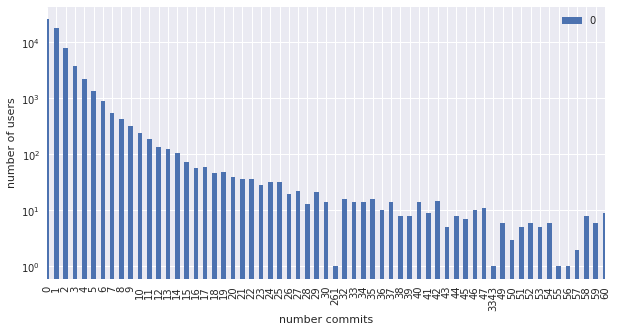

In [22]:
c = Counter(ucommits.values())
df = pd.DataFrame.from_dict(c, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number commits")
plt.ylabel("number of users")
plt.xlim([0,60])
plt.show()

In [55]:
for i, fname in enumerate(all_files[:1]):
    if i+1 %1 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        if "pull_request" in e['payload']:
            print e['payload']['pull_request']['updated_at']
        
        from pprint import pprint
#         pprint(e)


0 out of 720 files loaded
2015-01-13T02:00:08Z
2015-01-13T02:00:09Z
2015-01-13T02:00:11Z
2015-01-13T02:00:13Z
2015-01-13T02:00:13Z
2015-01-13T02:00:15Z
2015-01-13T02:00:16Z
2015-01-13T02:00:15Z
2015-01-13T02:00:20Z
2015-01-13T02:00:24Z
2015-01-13T02:00:25Z
2015-01-13T02:00:30Z
2015-01-13T02:00:39Z
2015-01-13T02:00:40Z
2015-01-13T02:00:45Z
2015-01-13T02:00:46Z
2015-01-13T02:00:46Z
2015-01-13T02:00:47Z
2015-01-13T02:00:49Z
2015-01-13T02:00:52Z
2015-01-13T02:00:54Z
2015-01-13T02:01:00Z
2015-01-13T02:01:08Z
2015-01-13T02:01:09Z
2015-01-13T02:01:11Z
2015-01-13T02:01:15Z
2015-01-13T02:01:16Z
2015-01-13T02:01:19Z
2015-01-13T02:01:21Z
2015-01-13T02:01:23Z
2015-01-13T02:01:25Z
2015-01-13T02:01:26Z
2015-01-13T02:01:26Z
2015-01-13T02:01:31Z
2015-01-13T02:01:34Z
2015-01-13T02:01:35Z
2015-01-13T02:01:37Z
2015-01-13T02:01:38Z
2015-01-13T02:01:38Z
2015-01-13T02:01:39Z
2015-01-13T02:01:40Z
2015-01-13T02:01:41Z
2015-01-13T02:01:46Z
2015-01-13T02:01:49Z
2015-01-13T02:01:54Z
2015-01-13T02:01:56Z
2015-01-

2015-01-13T02:30:16Z
2015-01-13T02:30:21Z
2015-01-13T02:30:23Z
2015-01-13T02:30:34Z
2015-01-13T02:30:37Z
2015-01-13T02:30:40Z
2015-01-13T02:30:45Z
2015-01-13T02:30:51Z
2015-01-13T02:30:51Z
2015-01-13T02:30:56Z
2015-01-13T02:30:59Z
2015-01-13T02:31:04Z
2015-01-13T02:31:10Z
2015-01-13T02:31:16Z
2015-01-13T02:31:18Z
2015-01-13T02:31:22Z
2015-01-13T02:31:29Z
2015-01-13T02:31:39Z
2015-01-13T02:31:52Z
2015-01-13T02:31:52Z
2015-01-13T02:31:53Z
2015-01-13T02:31:53Z
2015-01-13T02:31:57Z
2015-01-13T02:31:58Z
2015-01-13T02:31:59Z
2015-01-13T02:32:01Z
2015-01-13T02:32:02Z
2015-01-13T02:32:05Z
2015-01-13T02:32:07Z
2015-01-13T02:32:10Z
2015-01-13T02:32:17Z
2015-01-13T02:32:18Z
2015-01-13T02:32:19Z
2015-01-13T02:32:21Z
2015-01-13T02:32:23Z
2015-01-13T02:32:23Z
2015-01-13T02:32:31Z
2015-01-13T02:32:37Z
2015-01-13T02:32:39Z
2015-01-13T02:32:45Z
2015-01-13T02:32:44Z
2015-01-13T02:32:44Z
2015-01-13T02:32:47Z
2015-01-13T02:32:50Z
2015-01-13T02:32:54Z
2015-01-13T02:33:12Z
2015-01-13T02:33:12Z
2015-01-13T02

In [ ]:
for i, fname in enumerate(all_files[:n_files]):